Transfer Learning for Computer Vision 

Tutorial from Torch

In [1]:
## imports 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import numpy as np
import torchvision 
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import zipfile

plt.ion() # interactive mode

Extracting the data

In [2]:
with zipfile.ZipFile('/content/hymenoptera_data.zip', 'r') as f:
   # Extract all the contents of zip file in current directory
   f.extractall()

In [3]:
## Data augmentation and normalization for training 
## Just normalization for validation 

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'hymenoptera_data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                 for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Visualizing some images

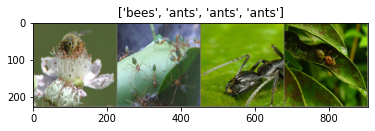

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # small pause so the plots are updated
    
# Get a training batch
inputs, classes = next(iter(dataloaders['train']))

# make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
- Scheduling the learning rate
- Saving the best model

In [5]:
# scheduler is the learning rate scheduler object from ```torch.optim.lr_scheduler```

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # set the model to training mode
            else:
                model.eval() # set the model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the gradients for the parameters
                optimizer.zero_grad()
                
                # forward 
                # track the history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f"Best val Acc: {best_acc:.4f}")
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


Visualizing the model predictions 

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetune the convnet

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# here the size of each output sample is set to 2
# alternativel, it can be generalized to nn.Linear(num_flters, len(class_names))

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# observe that all params are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of .1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Train and Evaluate 

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6622 Acc: 0.6680
val Loss: 0.1643 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.6113 Acc: 0.7623
val Loss: 0.3476 Acc: 0.8497

Epoch 2/24
----------
train Loss: 0.3679 Acc: 0.8238
val Loss: 0.2768 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.3789 Acc: 0.8238
val Loss: 0.3108 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.4051 Acc: 0.8566
val Loss: 0.2476 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.4958 Acc: 0.7992
val Loss: 0.3893 Acc: 0.8431

Epoch 6/24
----------
train Loss: 0.4092 Acc: 0.8361
val Loss: 0.3807 Acc: 0.8497

Epoch 7/24
----------
train Loss: 0.3080 Acc: 0.8648
val Loss: 0.2627 Acc: 0.8693

Epoch 8/24
----------
train Loss: 0.3474 Acc: 0.8689
val Loss: 0.2346 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.3079 Acc: 0.8730
val Loss: 0.2157 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3786 Acc: 0.8402
val Loss: 0.2298 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.2129 Acc: 0.9139
val Loss: 0.2062 Acc: 0.9216

Ep

ConvNet as fixed feature extractor

In [9]:
## here were freezing all the layers except the final layer
# we set up requires_grad == False to freeze the weights so the gradients are not computed 
# in the backward()

In [11]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as 
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by the factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and Evaluate Model

In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                        exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6918 Acc: 0.6107
val Loss: 0.2922 Acc: 0.8824

Epoch 1/24
----------
train Loss: 0.3823 Acc: 0.8320
val Loss: 0.5343 Acc: 0.7712

Epoch 2/24
----------
train Loss: 0.4980 Acc: 0.7992
val Loss: 0.1769 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.6343 Acc: 0.7746
val Loss: 0.2343 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.3403 Acc: 0.8730
val Loss: 0.3385 Acc: 0.8693

Epoch 5/24
----------
train Loss: 0.3697 Acc: 0.8648
val Loss: 0.1962 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.4525 Acc: 0.8238
val Loss: 0.3618 Acc: 0.8693

Epoch 7/24
----------
train Loss: 0.3887 Acc: 0.8484
val Loss: 0.2005 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3127 Acc: 0.8730
val Loss: 0.2319 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3062 Acc: 0.8566
val Loss: 0.1959 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3743 Acc: 0.8320
val Loss: 0.2078 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3534 Acc: 0.8279
val Loss: 0.1855 Acc: 0.9346

Ep

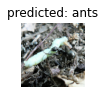

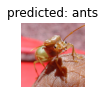

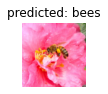

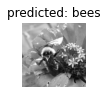

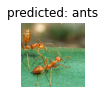

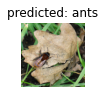

In [13]:
## Visualize the model
visualize_model(model_conv)

plt.ioff()
plt.show()